# Identifying features for prediction of heart disease

The target is to build an heart disease predictor and evaluate which features are predictive for heart disease. The dataset used for this is the "processed.cleveland.data" file from https://archive.ics.uci.edu/ml/datasets/Heart+Disease.

The approach chosen to solve this is predictive modelling. General steps will likely be:
 1. loading and exploring the data
 2. processing and cleaning it for model training
 3. model training
 4. Hyperparameter tuning
 5. Evaluation
 6. Visualisation
 
There will be iteration on steps 2-6.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import shap

import numpy as np

In [2]:
heart_ds = pd.read_csv('../data/processed.cleveland.data', names=range(1,15))

In [3]:
heart_ds.loc[heart_ds[14] > 0, 14] = 1
heart_ds.replace(to_replace='?', value=-9, inplace=True)
heart_ds[[12, 13]] = heart_ds[[12, 13]].astype('float64')

In [4]:
heart_ds.rename(columns={1: 'age', 2: 'sex', 3: 'chest_pain_type', 4: 'rest_blood_pressure', 
                         5: 'cholesterol', 6: 'fast_blood_sugar', 7: 'rest_ecg', 8: 'max_hr', 
                         9: 'ex_ang', 10: 'st_depression', 11: 'slope', 12: 'colrd_vessels', 
                         13: 'thal',  14: 'heart_disease'}, inplace=True)

In [5]:
heart_ds

,age,sex,chest_pain_type,rest_blood_pressure,cholesterol,fast_blood_sugar,rest_ecg,max_hr,ex_ang,st_depression,slope,colrd_vessels,thal,heart_disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,1
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


In [6]:
print("Patients with hear_disease",(heart_ds['heart_disease'] == 1).sum())
print("Patients without hear_disease", (heart_ds['heart_disease'] == 0).sum())

Patients with hear_disease 139
Patients without hear_disease 164


In [7]:
X = heart_ds.drop(columns='heart_disease')
y = heart_ds['heart_disease'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2, stratify=y)

In [8]:
list(y_test).count(1)

28

In [9]:
clf = RandomForestClassifier(n_estimators=500, max_depth=8, class_weight='balanced',random_state=2)

In [10]:
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
acc_score = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {acc_score}")
print(f"{f1=}")

Accuracy: 0.8524590163934426
f1=0.830188679245283


In [11]:
for i in range(0, len(clf.feature_importances_)):
    print(f"{X.columns[i]} : {clf.feature_importances_[i]}")


age : 0.07623469316074588
sex : 0.03835226213936642
chest_pain_type : 0.14724217033972634
rest_blood_pressure : 0.07618025525666343
cholesterol : 0.07329024933263001
fast_blood_sugar : 0.010036195923734236
rest_ecg : 0.025953307259161278
max_hr : 0.10547006397687907
ex_ang : 0.04523017951399813
st_depression : 0.09785112220330507
slope : 0.0513778585757481
colrd_vessels : 0.10601014141993234
thal : 0.14677150089810992


This is a decent baseline model. To improve on it we can run a grid search on hyperparameters. Normalization through a scalar will not be beneficial as tree based methods are finding decision thresholds and that works equally well with non scaled parameters.

In [12]:
%%time
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced',)
params = {'n_estimators': [ 20, 25, 30, 35, 50, 100], 
         'max_depth': [ 2, 3, 4, 5, 6, 8, 10 ], 
         'criterion': ["gini", "entropy"],
         'min_samples_split': [30, 40, 50, 60, 70],  
          'min_samples_leaf': [3, 4,5,8 ]}
grid_clf = GridSearchCV(rf_clf, params, cv=5, scoring=['accuracy', 'f1', 'precision', 'recall'], 
                        refit='f1', n_jobs=-1, return_train_score=True)
grid_clf.fit(x_train, y_train)

CPU times: user 9.2 s, sys: 365 ms, total: 9.56 s
Wall time: 2min 4s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 8, 10],
                         'min_samples_leaf': [3, 4, 5, 8],
                         'min_samples_split': [30, 40, 50, 60, 70],
                         'n_estimators': [20, 25, 30, 35, 50, 100]},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall'])

In [13]:
print(grid_clf.best_score_)
print(grid_clf.best_params_)
print(grid_clf.best_index_)


0.8383855360325947
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 40, 'n_estimators': 35}
1119


In [14]:
cv_results = pd.DataFrame(grid_clf.cv_results_)
cv_results[['mean_train_accuracy', 'mean_test_accuracy', 'mean_test_recall', 'mean_test_f1', 'mean_test_precision' ]][141:142]


,mean_train_accuracy,mean_test_accuracy,mean_test_recall,mean_test_f1,mean_test_precision
141,0.862587,0.838861,0.828458,0.826132,0.830441


In [15]:
best_rf = grid_clf.best_estimator_

In [16]:
y_pred = grid_clf.predict(x_test)
acc_score = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {acc_score}")
print(f"{f1=}")

list(y_test).count(1)

Accuracy: 0.8524590163934426
f1=0.830188679245283


28

In [17]:
for i in range(0, len(best_rf.feature_importances_)):
    print(f"{X.columns[i]} : {best_rf.feature_importances_[i]}")


age : 0.025223352665997546
sex : 0.04767724693655114
chest_pain_type : 0.1682477367756438
rest_blood_pressure : 0.017050950661041005
cholesterol : 0.02403916403787304
fast_blood_sugar : 0.0017212797275890444
rest_ecg : 0.01724414385516326
max_hr : 0.10060294298830418
ex_ang : 0.0800624982488786
st_depression : 0.07222797807122032
slope : 0.08960314762928841
colrd_vessels : 0.17027942353648567
thal : 0.18602013486596405


In [18]:
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X)

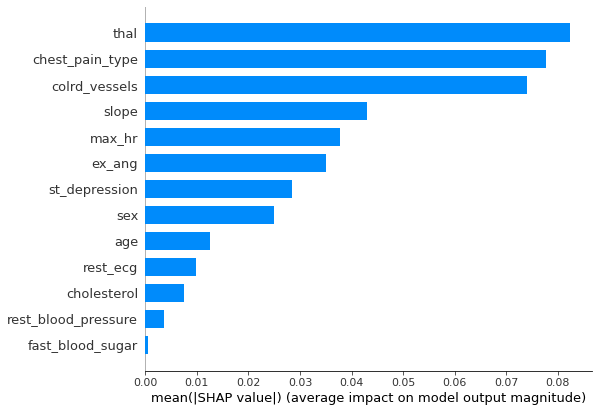

In [19]:
shap.summary_plot(shap_values[1], X, plot_type='bar', show=False)
plt.savefig('shap_bar.png', dpi=200, bbox_inches='tight')
plt.show()


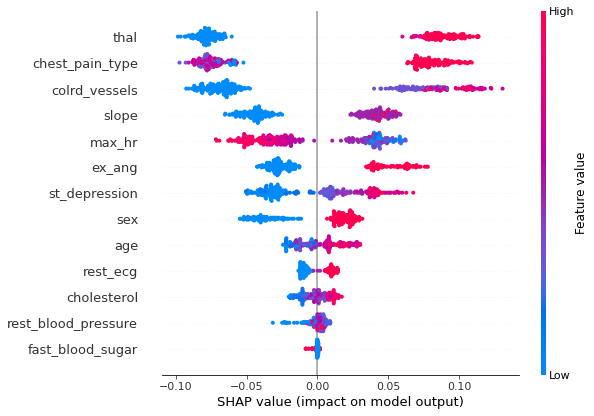

In [20]:
shap.summary_plot(shap_values[1], X, plot_type='dot',show=False)
plt.savefig('shap_summary.png', dpi=200, bbox_inches='tight')
plt.show()

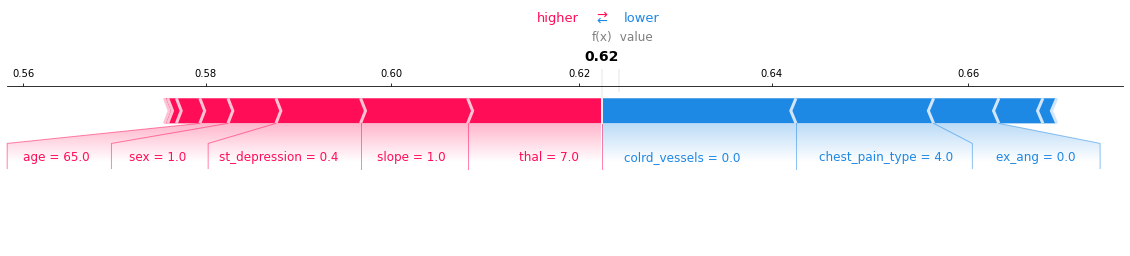

In [21]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], x_test.iloc[0,:], link="logit", show=False, matplotlib=True)
plt.savefig('shap_force.png', dpi=200)
plt.show()

## Experiment with a Support Vector Machine Model

In [22]:
svc = SVC()

In [23]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

In [24]:
svr_CV = GridSearchCV(pipe, param_grid={'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                                       'svc__tol': [1e-3, 1e-2, 1e-1]},
                      scoring='f1',
                      cv=5, verbose=False, n_jobs=-1)

In [25]:
svr_CV.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'svc__tol': [0.001, 0.01, 0.1]},
             scoring='f1', verbose=False)

In [26]:
svr_CV.best_score_

0.8193872727763823

In [27]:
x_test.iloc[0,:]

age                     65.0
sex                      1.0
chest_pain_type          4.0
rest_blood_pressure    120.0
cholesterol            177.0
fast_blood_sugar         0.0
rest_ecg                 0.0
max_hr                 140.0
ex_ang                   0.0
st_depression            0.4
slope                    1.0
colrd_vessels            0.0
thal                     7.0
Name: 51, dtype: float64